In [19]:
#limpio la memoria
rm(list=ls())
gc()

#cargo librerias
library("data.table")
library("ROCR")
library("rpart")
library("rpart.plot")
library("caret")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2433327,130.0,4785948,255.6,4785948,255.6
Vcells,4202188,32.1,214426872,1636.0,268019355,2044.9


In [20]:
setwd("/home/devsar/Documents/Austral/Laboratorio de Implementación")

#Parametros entrada

#kcarpeta_datasets    <- "../input/laboratorio-de-implementacion-i-2021/"   #KAGGLE
kcarpeta_datasets    <- "./datasets/"                          #VM o Ubuntu

#Archivo con datos etiquetados para entrenamiento
karchivo_entrada      <-  paste0(kcarpeta_datasets, "competencia1_2022_FE_4.csv")

#Formato para submit en Kaggle
#karchivo_score      <-  "../input/uamds2020ldi1f1/Sample_201910_Fase_I.txt"

#Separador de campos en archivos
kcampos_separador     <-  "\t"

#Campo que identifica las muestras
kcampo_id             <-  "numero_de_cliente"

#Campo que contiene la clase a estimar
kclase_nomcampo       <-  "clase_ternaria"

#Valor de interés
kclase_valor_positivo <-  "BAJA+2"

#Campos a borrar para el entrenamiento
kcampos_a_borrar      <-  c(kcampo_id,kclase_nomcampo,"foto_mes")

#Campo que contendrá a la variable objetivo generada
kobjetivo             <-  "clase"

#Identificación del modelo
kmodelo               <-  "02-RPART"

#Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000

#Establezco semilla aleatoria
set.seed(1)



In [21]:
#cargo los datos
dataset <- fread(karchivo_entrada)

#Para hacer pruebas rapidas puedo reducir el dataset a una fraccion
#subsample <- sample(1:nrow(dataset), .1 * nrow(dataset))
#dataset <- dataset[subsample,]

dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar
dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo

In [22]:
#Genero la clase
dataset[,(kobjetivo) := as.integer(dataset[,..kclase_nomcampo] == kclase_valor_positivo)]

#Limpio campos a borrar
dataset[ ,  (kcampos_a_borrar) := NULL    ] 

#Completo missings
dataset[is.na(dataset)] <- 0

Warning message in `[.data.table`(dataset, , ..kclase_nomcampo):
“Both 'kclase_nomcampo' and '..kclase_nomcampo' exist in calling scope. Please remove the '..kclase_nomcampo' variable in calling scope for clarity.”


In [23]:
# generacion del modelo
variables = ". -Master_delinquency-Master_status-Master_mfinanciacion_limite-Master_Fvencimiento-Master_Finiciomora-Master_msaldototal-Master_msaldopesos-Master_msaldodolares-Master_mconsumospesos-Master_mconsumosdolares-Master_mlimitecompra-Master_madelantopesos-Master_madelantodolares-Master_fultimo_cierre-Master_mpagado-Master_mpagospesos-Master_mpagosdolares-Master_fechaalta-Master_mconsumototal-Master_cconsumos-Master_cadelantosefectivo-Master_mpagominimo-Visa_delinquency-Visa_status-Visa_mfinanciacion_limite-Visa_Fvencimiento-Visa_Finiciomora-Visa_msaldototal-Visa_msaldopesos-Visa_msaldodolares-Visa_mconsumospesos-Visa_mconsumosdolares-Visa_mlimitecompra-Visa_madelantopesos-Visa_madelantodolares-Visa_fultimo_cierre-Visa_mpagado-Visa_mpagospesos-Visa_mpagosdolares-Visa_fechaalta-Visa_mconsumototal-Visa_cconsumos-Visa_cadelantosefectivo-Visa_mpagominimo"
formula = paste("clase_ternaria ~", variables)

In [24]:
#cargo los datos
dataset <- fread(karchivo_entrada)

#Para hacer pruebas rapidas puedo reducir el dataset a una fraccion
#subsample <- sample(1:nrow(dataset), .1 * nrow(dataset))
#dataset <- dataset[subsample,]

dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar

train_rows <- createDataPartition(dtrain$clase, p = .66, list = FALSE)

#train_rows <- sample(1:nrow(dataset), .66 * nrow(dataset))
dtest <- dtrain[-train_rows,]
dtrain <- dtrain[train_rows,]

dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo

In [25]:
#Genero el modelo
t0       <-  Sys.time()
modelo   <-  rpart(formula,   data = dtrain, maxdepth = 7,  cp=-0.005, minsplit=900, minbucket=60,   xval=0)
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)

[1] 5.958047


In [26]:
#Detalles del modelo
modelo

n= 106487 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 106487 1000 CONTINUA (0.0041225690 0.0052682487 0.9906091823)  
    2) ctrx_quarter< 13.5 5511  460 CONTINUA (0.0335692252 0.0499001996 0.9165305752)  
      4) g_saldo_total< -1011.285 1843  268 CONTINUA (0.0591427021 0.0862723820 0.8545849159)  
        8) cprestamos_personales< 1.5 1470  255 CONTINUA (0.0707482993 0.1027210884 0.8265306122)  
         16) cdescubierto_preacordado< 0.5 220   81 CONTINUA (0.1590909091 0.2090909091 0.6318181818) *
         17) cdescubierto_preacordado>=0.5 1250  174 CONTINUA (0.0552000000 0.0840000000 0.8608000000)  
           34) mpasivos_margen< 44.515 1043  165 CONTINUA (0.0623202301 0.0958772771 0.8418024928)  
             68) cliente_antiguedad>=25.5 740  140 CONTINUA (0.0756756757 0.1135135135 0.8108108108) *
             69) cliente_antiguedad< 25.5 303   25 CONTINUA (0.0297029703 0.0528052805 0.9174917492) *
           35) mpasivos_margen>=44.515 207    

Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”


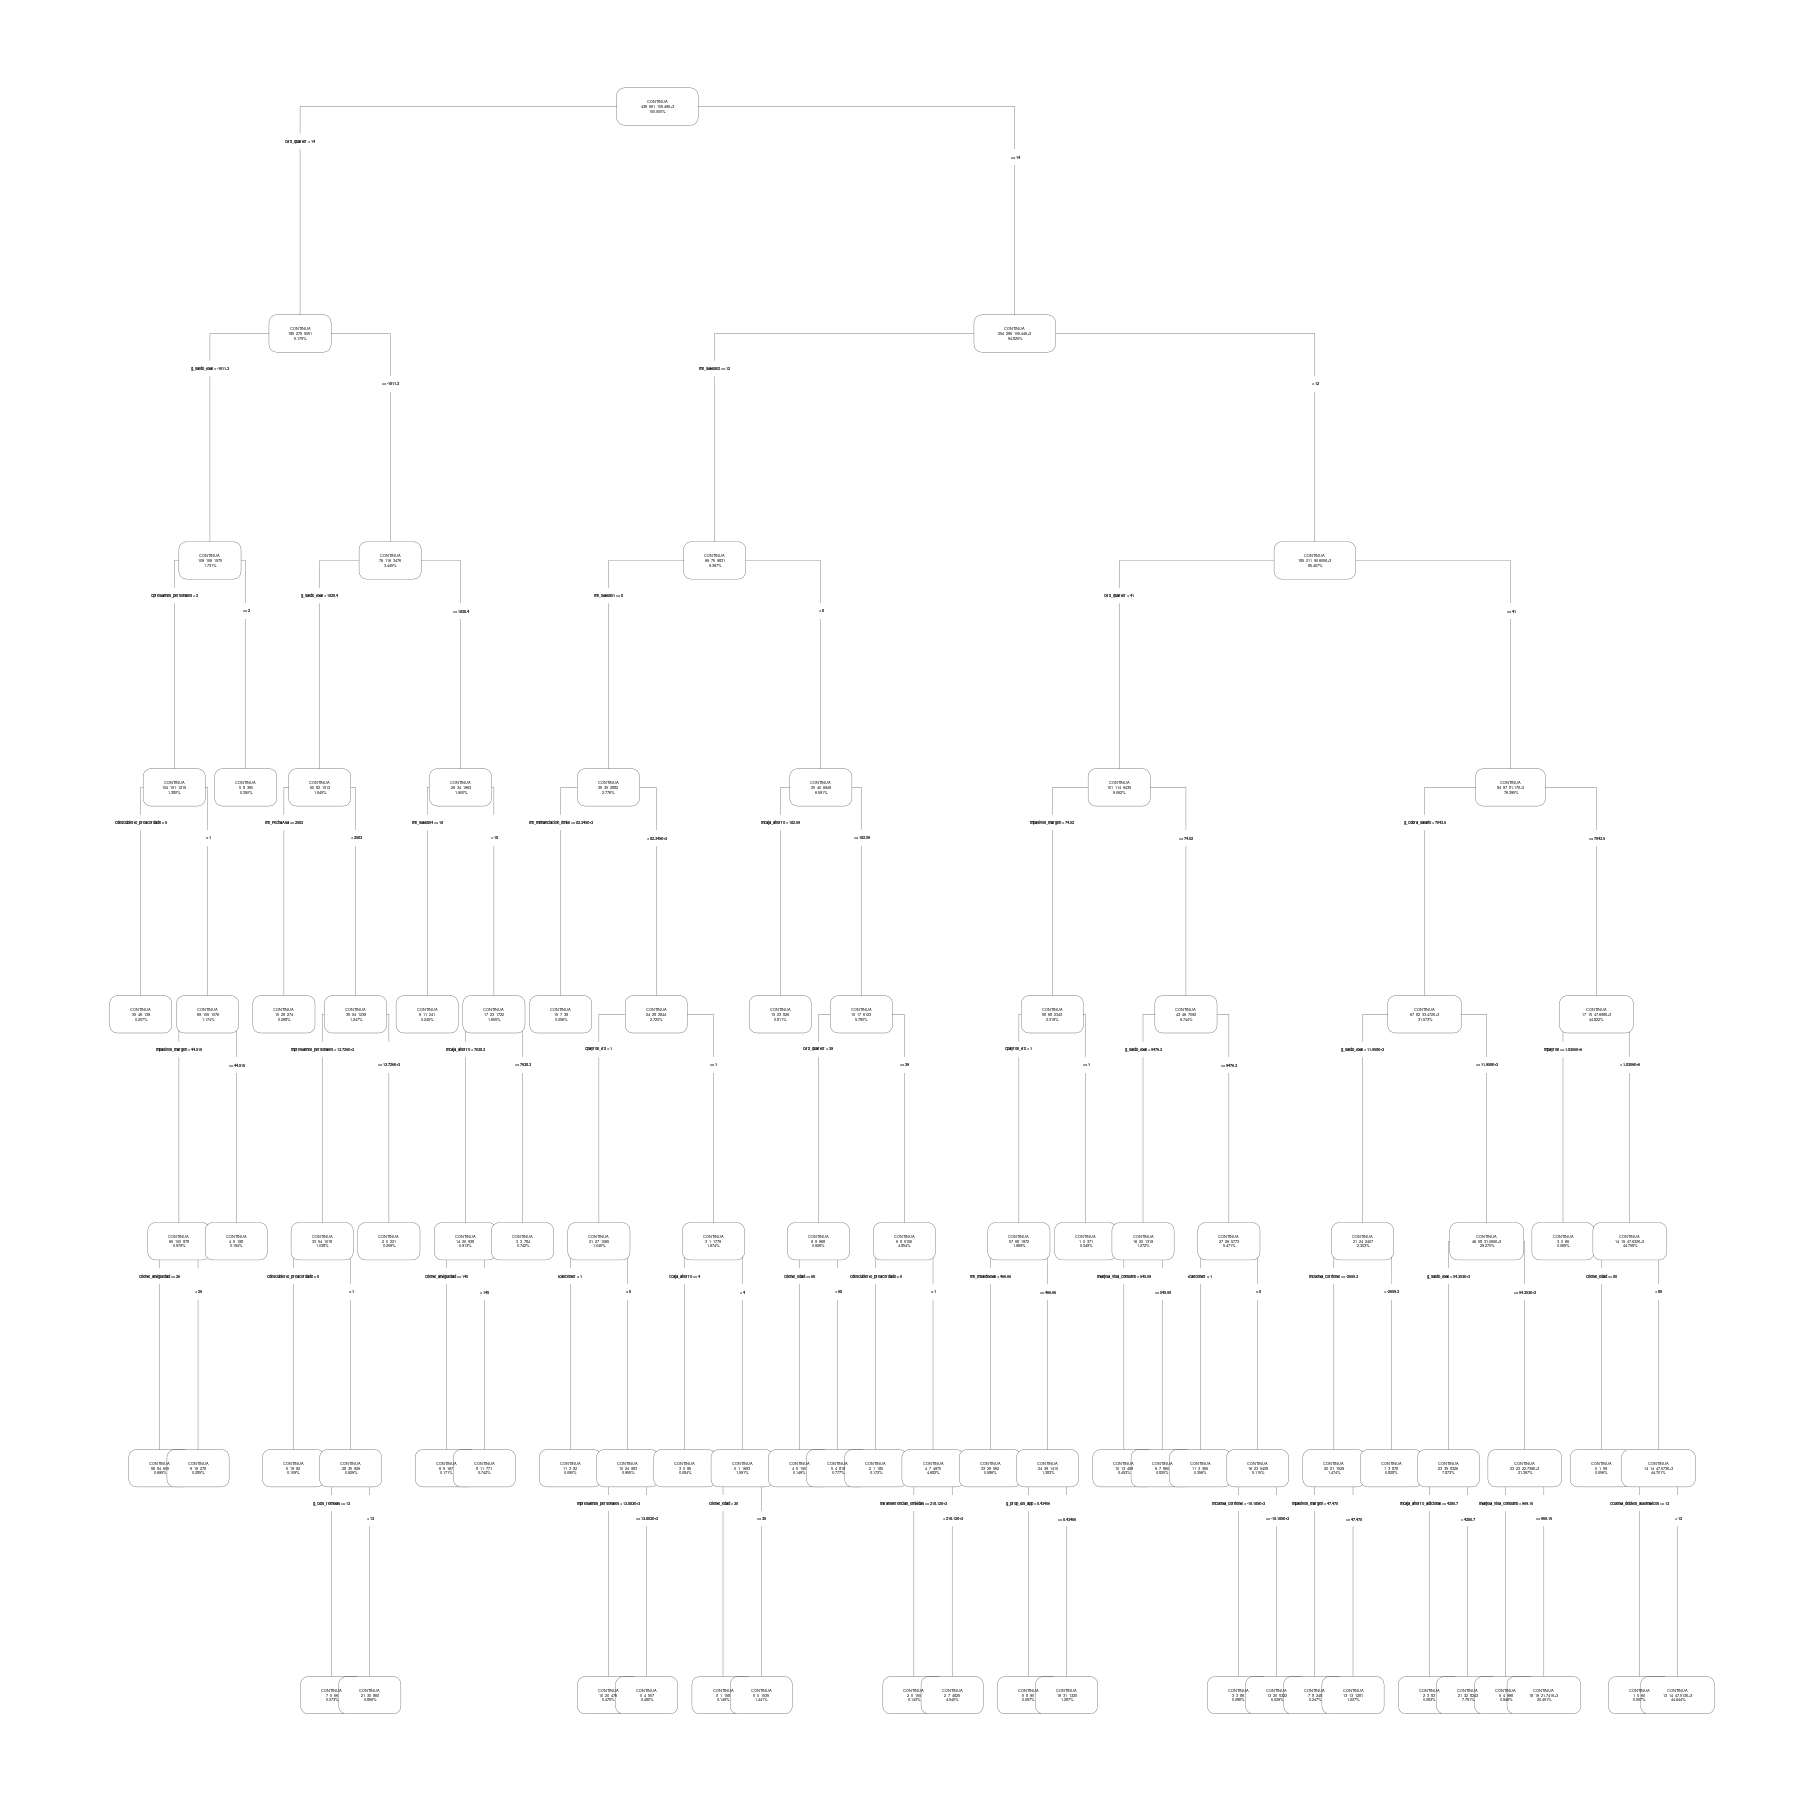

In [27]:
#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [28]:
#Evalúo sobre test
prediccion <- predict(modelo, dtest,) # predicted values

#Calculo ganancia sobre dataset de pruebas
dtest[ , prob_baja2 := prediccion[, "BAJA+2"] ]
dtest[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]


#calculo la ganancia de incentivar cada caso
dtest[  , ganancia:= kFPGain ] #-1250
dtest[ clase_ternaria=='BAJA+2',   ganancia:= kTPGain] #48750


#Determino ganancia
print(paste("La Ganancia es:", 3*sum(dtest$Predicted*dtest$ganancia)))

[1] "La Ganancia es: 17178000"


[[1]]
[1] 0.8640442

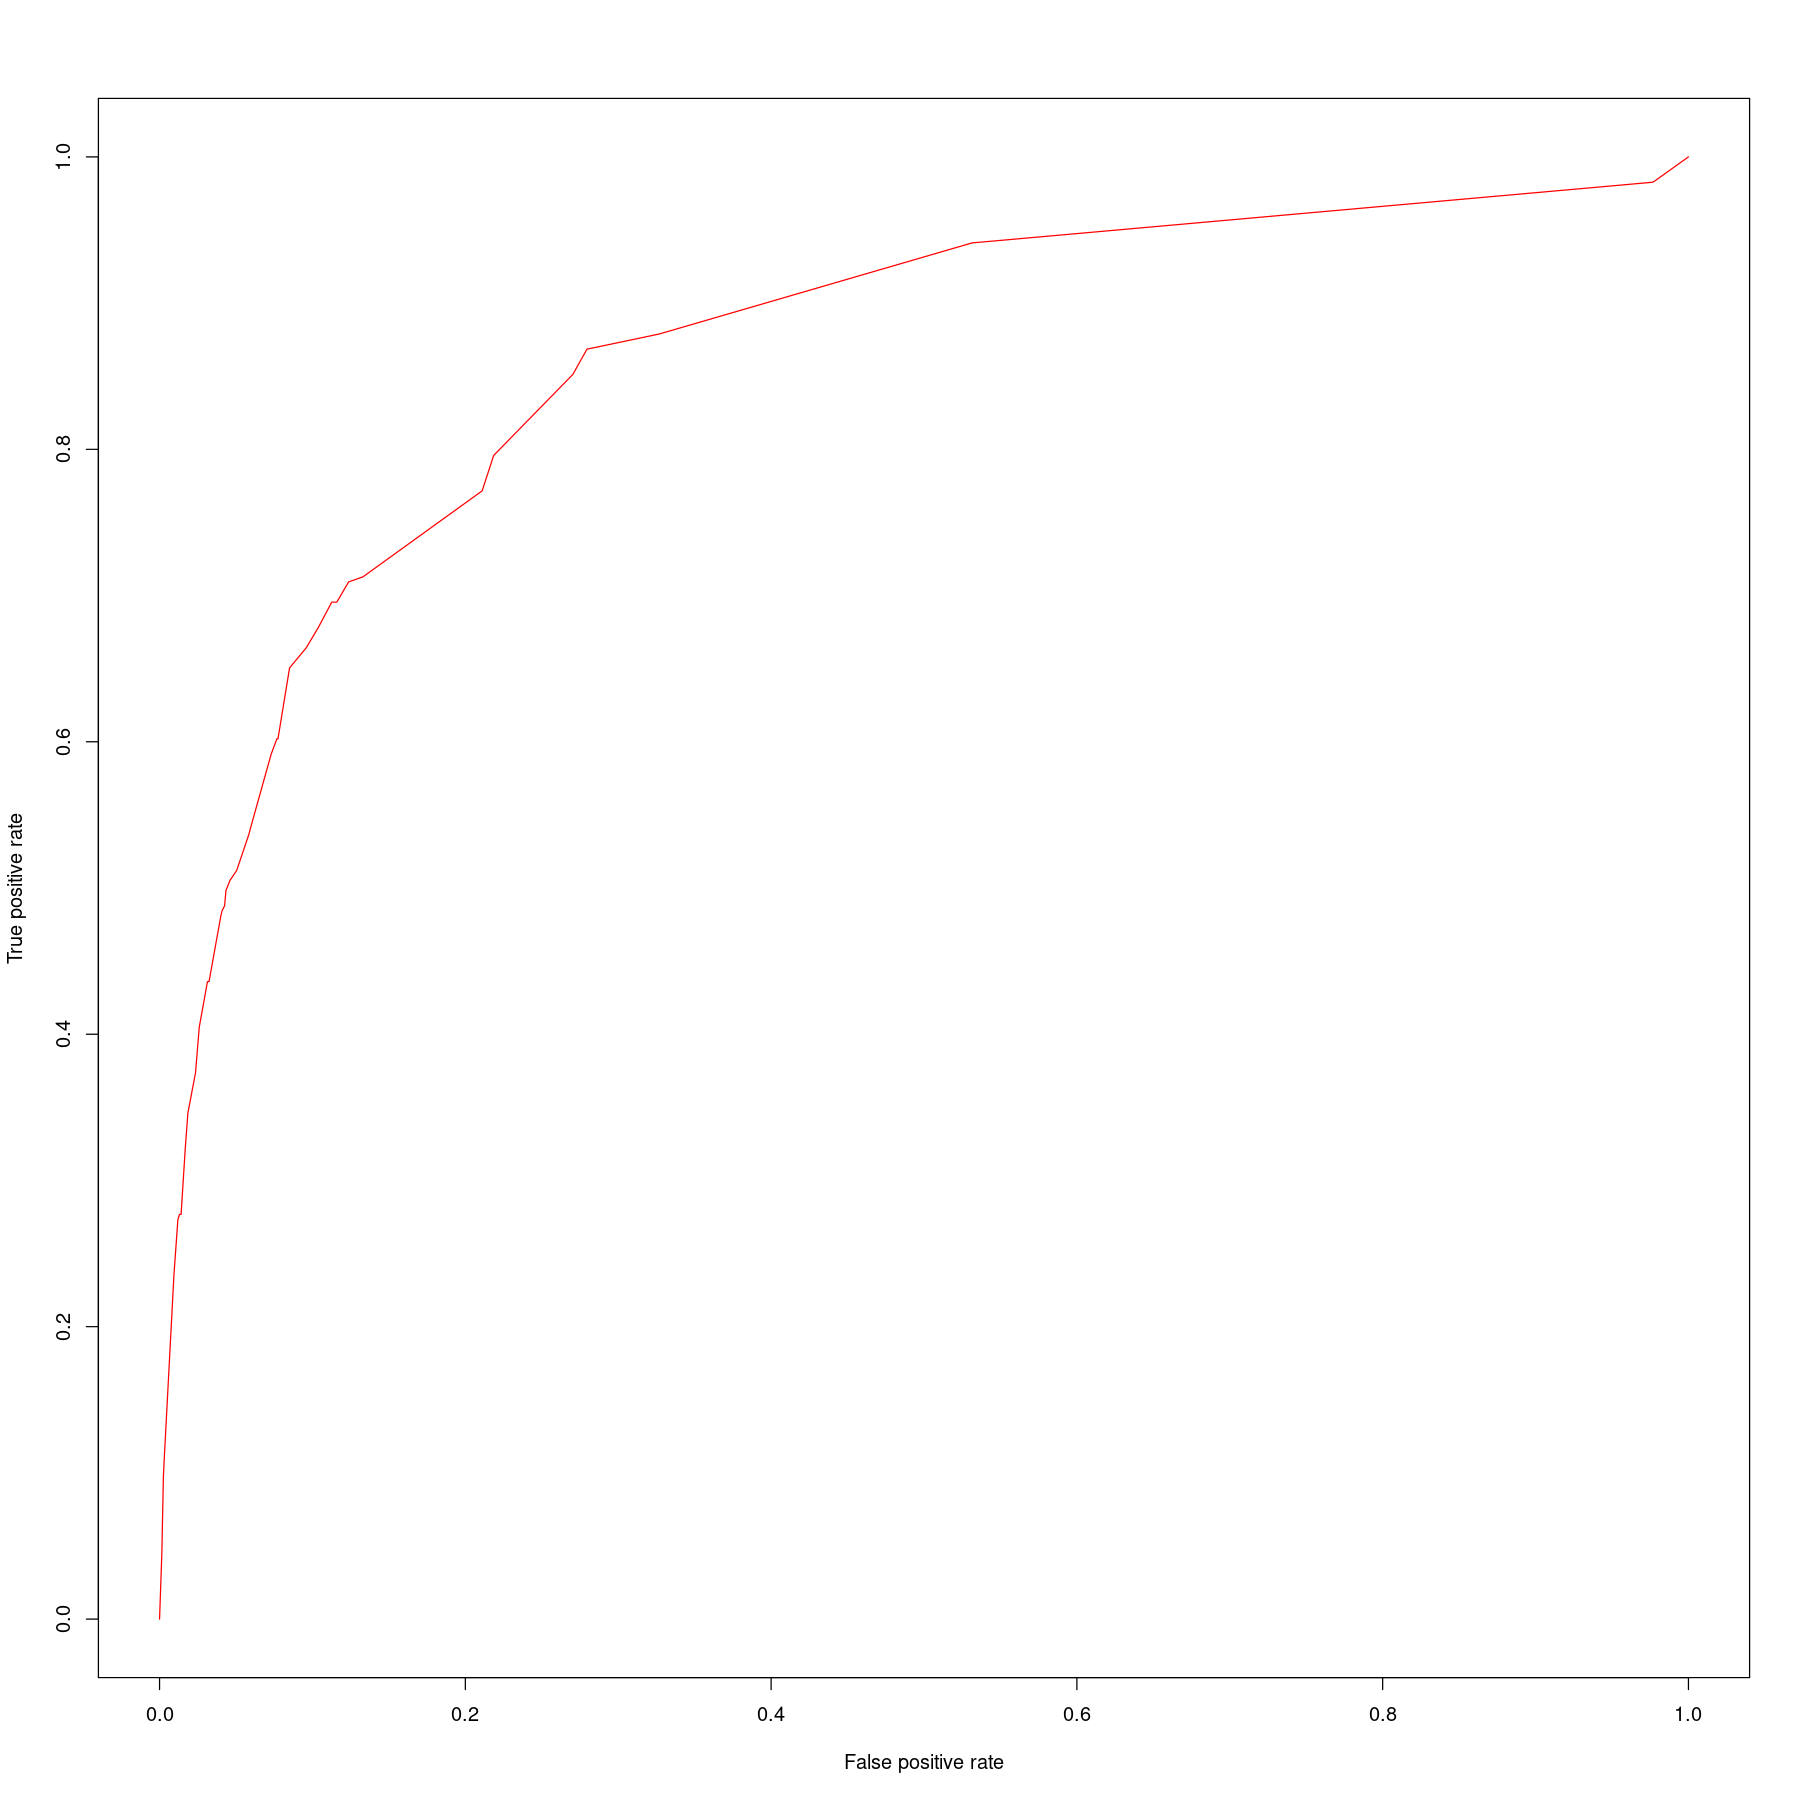

In [29]:
#Calculo las metricas
pred <- prediction(dtest$prob_baja2, dtest$clase_ternaria=='BAJA+2')

#Calculo las metricas
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

#Grafico la ROC
plot(perf, col=rainbow(10))

#Determino AUC
performance( pred,"auc")@y.values

[1] 3.129315


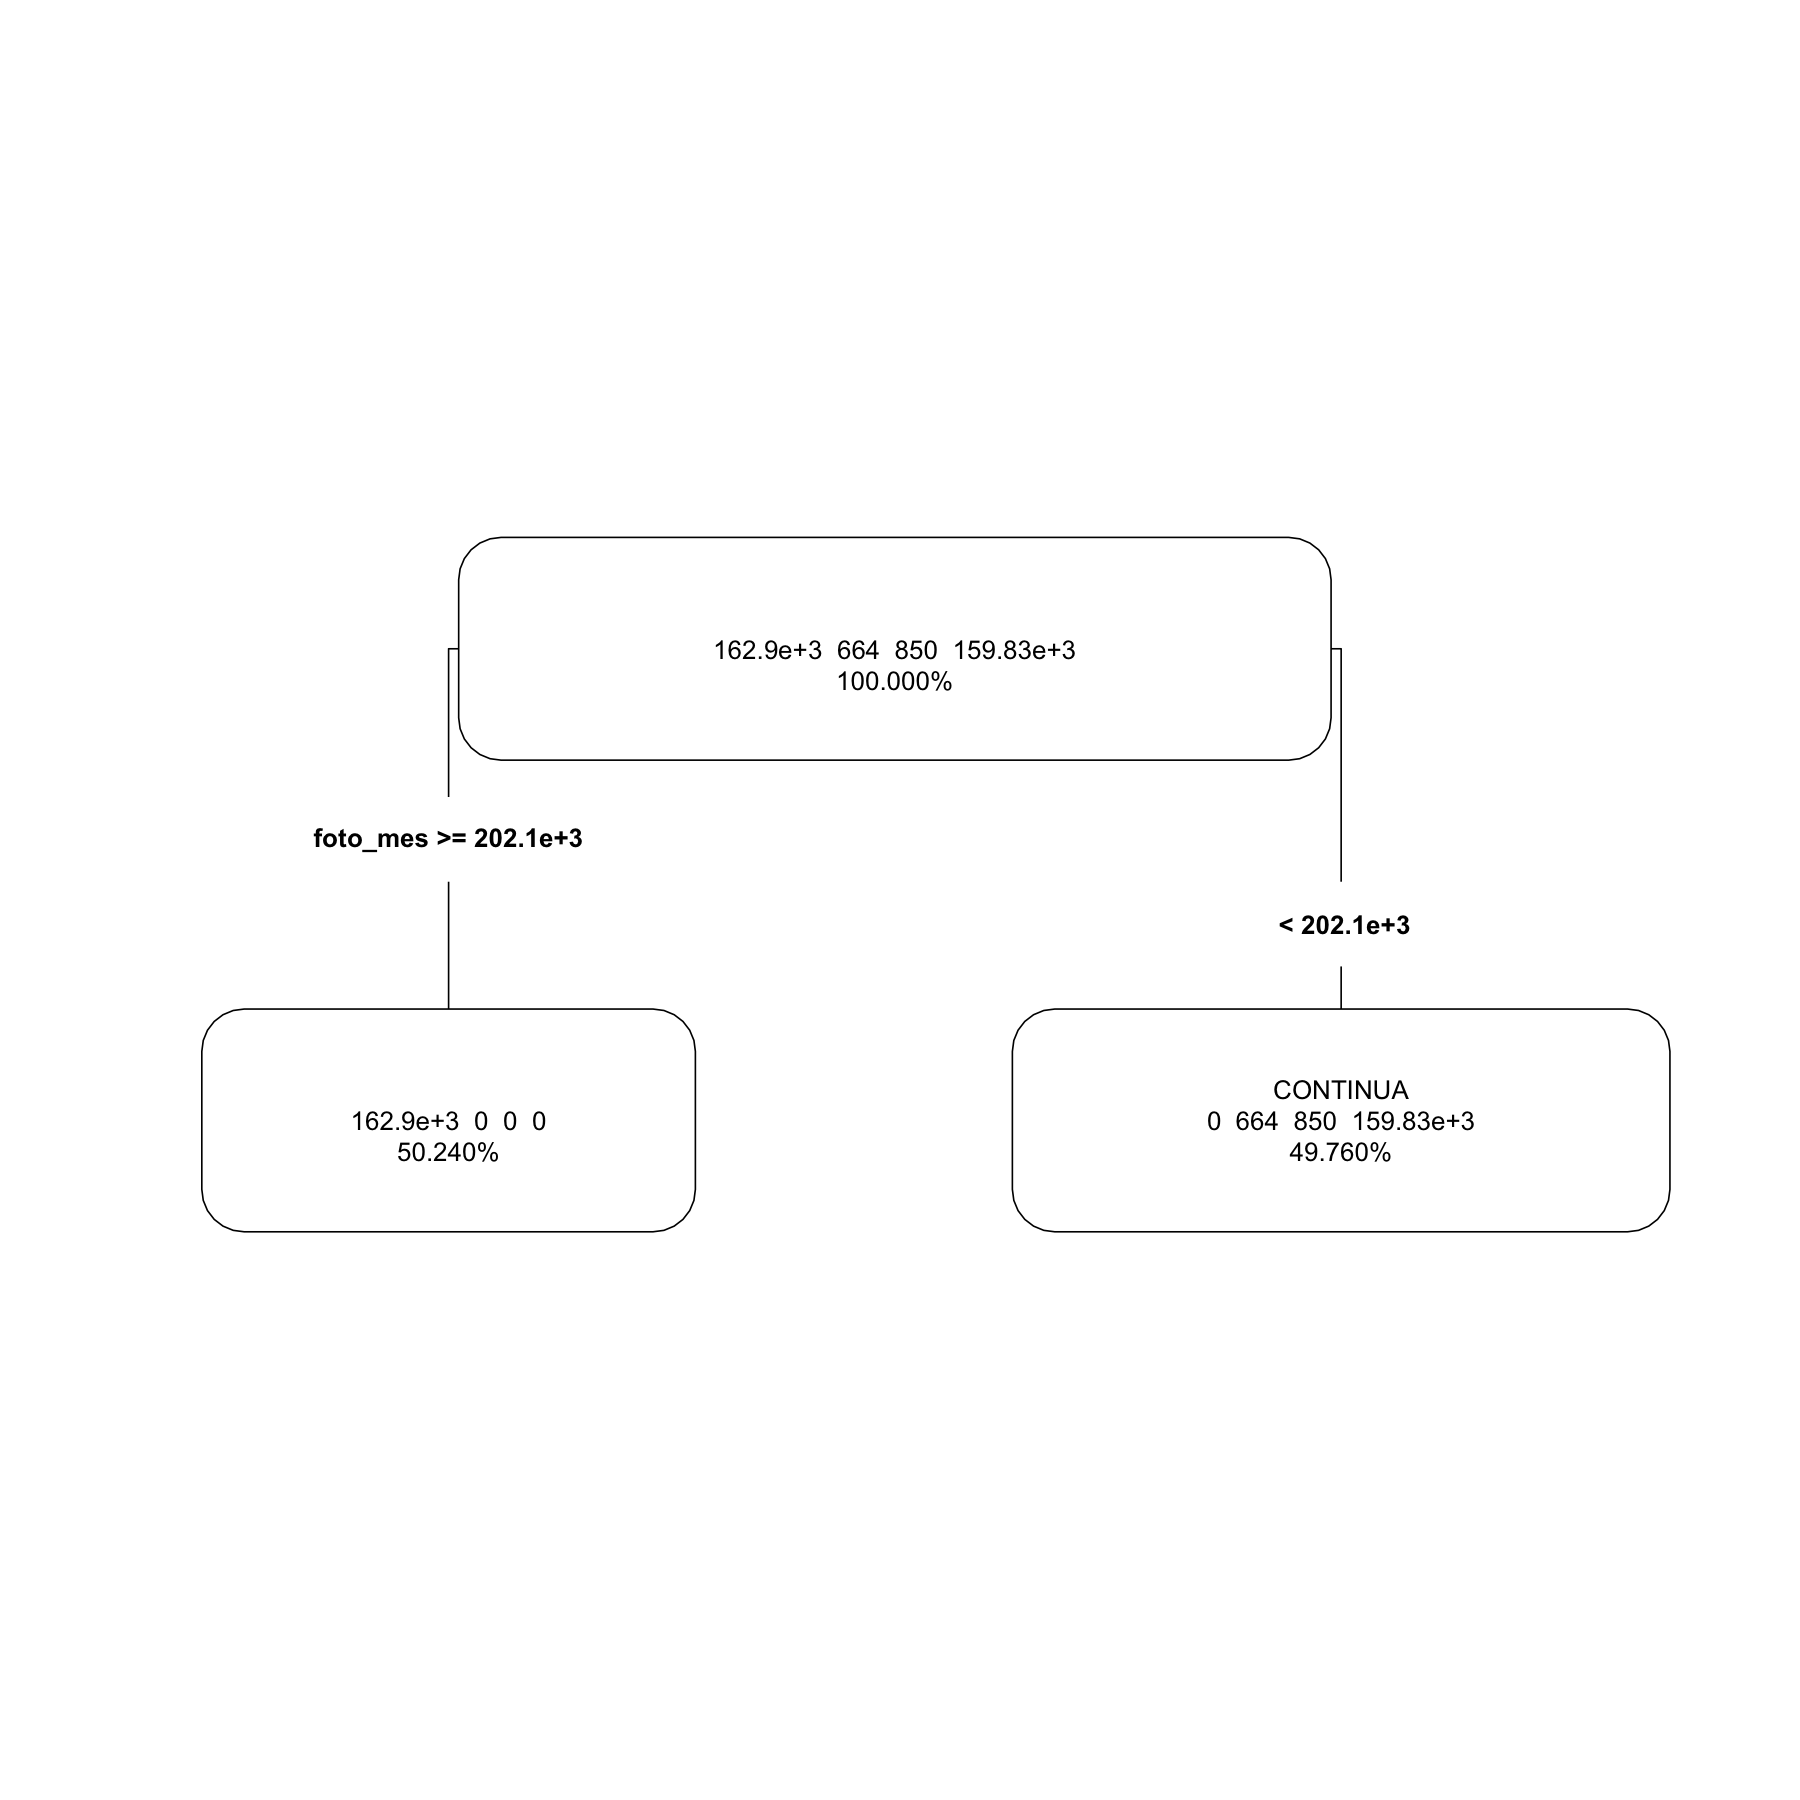

In [16]:
#Genero el modelo sobre dataset completo

t0       <-  Sys.time()
modelo   <-  rpart("clase_ternaria ~ .",   data = dataset, maxdepth = 2,  cp=0,   xval=0)
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)

#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [18]:
prediccion  <- predict( modelo, dapply , type = "prob") #aplico el modelo
dapply[ , prob_baja2 := prediccion[, "BAJA+2"] ]
dapply[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]
dir.create( "./exp/KA2002" )
fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= "./exp/KA2002/KA2002_001.csv", 
        sep= "," )

Warning message in dir.create("./exp/KA2002"):
“'./exp/KA2002' ya existe”
